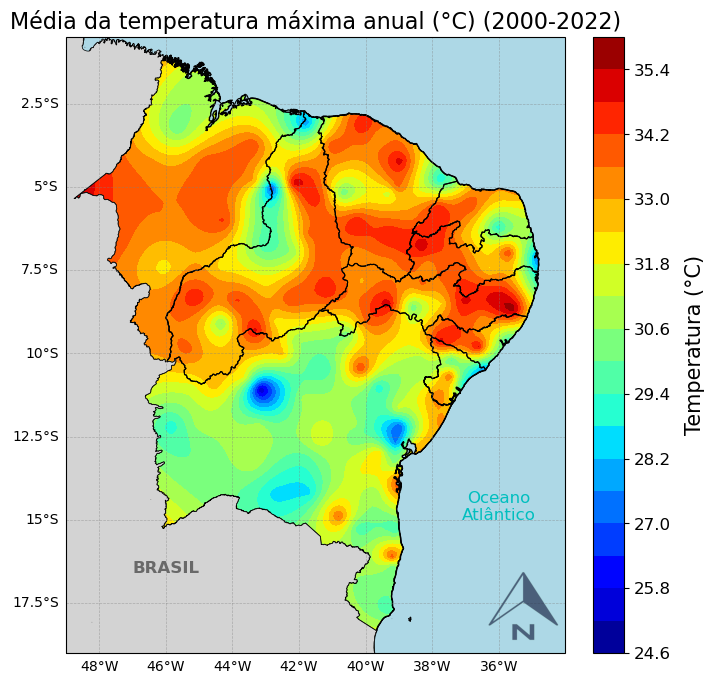

In [27]:
### PLOTANDO MAPA DE DIST. ESPACIAL DA MEDIA ANUAL DA TEMP MAX ###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
from PIL import Image
from src.IDW import IDW
from src.RBF import RBF
from src.utils import coordsTransform, reshape_grid

df = pd.read_csv('data.csv', sep=';', decimal=',', encoding='utf-8')
df = df.groupby(['Estacao', 'LAT', 'LONG']).mean().reset_index()
df = df[['Estacao', 'Tmax_C', 'Tmin_C', 'Umidade_relativa', 'LAT', 'LONG']]

x = df['LONG'].values
y = df['LAT'].values
z = df['Tmax_C'].values

#definir limites de lat e long
yi = np.arange(-19, -0.4, 0.1)
xi = np.arange(-49, -33, 0.1)

# Transformar as coordenadas da grade
long, lat = coordsTransform(xi, yi)

# Realizar a interpolação usando o método RBF (Radial Basis Function)
# Utilizando levels=20 na linha "c = ax.contourf(long, lat, np.clip(estimado, 24, 36), levels=20, cmap='jet', transform=ccrs.PlateCarree())"
# Fica muito semelhante à interpolação Kriging
z_estimado = RBF(x, y, z, long, lat)

# Gerar a grade 2D dos valores estimados
long, lat, estimado = reshape_grid(xi, yi, z_estimado)

# Preparando figura para fazer o plot
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-49, -34, -19, -0.5], ccrs.PlateCarree())
gd = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5) 
gd.right_labels = False
gd.top_labels = False
#Recursos do Cartopy
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.LAKES, alpha=0.5)
# ax.add_feature(cfeature.RIVERS)
# ax.add_feature(cfeature.STATES)
# ax.add_feature(cfeature.LAND, zorder=2, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN.with_scale('10m'), zorder=2, edgecolor='black', facecolor='lightblue')

# Lendo shp do Nordeste
shape_feature = ShapelyFeature(shpreader.Reader('Shapes_Nordeste/Nordeste_SIRGAS2000_IBGE_2017.shp').geometries(),\
ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=0.8, zorder=2)
ax.add_feature(shape_feature)

# Lendo shp dos arredores do Nordeste
shape_arredores = ShapelyFeature(shpreader.Reader('Shapes_Nordeste/teste.shp').geometries(),\
ccrs.PlateCarree(), facecolor='lightgray', edgecolor='k', linewidth=0.5, zorder=2)
ax.add_feature(shape_arredores)

#caso queira plotar os pontos das estações
# cs = ax.scatter(df['LONG'].values, df['LAT'].values,\
#                  transform=ccrs.PlateCarree(), marker='o', s=20, zorder=3)

# c = ax.contourf(long, lat, estimado, levels=20, cmap='jet', transform=ccrs.PlateCarree())
c = ax.contourf(long, lat, np.clip(estimado, 24, 36), levels=20, cmap='jet', transform=ccrs.PlateCarree())
cbar = plt.colorbar(c, ax=ax, pad=0.03)
cbar.set_label(label='Temperatura (°C)', size=15, labelpad=10)
cbar.ax.tick_params(labelsize=12)

seta = Image.open("Shapes_Nordeste/norte.png")
# Adicionar a imagem ao mapa
ax.imshow(seta, extent=[-37, -33.5, -18.7, -16.5], alpha=0.7, zorder=3)

ax.text(-36.01, -15.0, 'Oceano\nAtlântico', fontsize=12, transform=ccrs.PlateCarree(), color='c', horizontalalignment='center')
ax.text(-47, -16.6, 'BRASIL', fontsize=12, transform=ccrs.PlateCarree(), color='dimgray', fontweight='bold')

ax.set_title('Média da temperatura máxima anual (°C) (2000-2022)', fontsize=16)

plt.savefig('jet_tmax_anual.png', dpi=300, bbox_inches='tight')

plt.show()